In [ ]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM, ReLU

Importing Data from Tiingo

In [ ]:
df = pdr.DataReader('GOOG','tiingo',api_key='07a549dfd2aaaf0bb130c21d539b0fbdf95c2476')

In [ ]:
df.shape

(1257, 12)

In [ ]:
df.head(5)

close    high  ...  divCash  splitFactor
symbol date                                       ...                      
GOOG   2016-08-15 00:00:00+00:00  782.44  787.49  ...      0.0          1.0
       2016-08-16 00:00:00+00:00  777.14  780.98  ...      0.0          1.0
       2016-08-17 00:00:00+00:00  779.91  780.81  ...      0.0          1.0
       2016-08-18 00:00:00+00:00  777.50  782.86  ...      0.0          1.0
       2016-08-19 00:00:00+00:00  775.42  777.10  ...      0.0          1.0

[5 rows x 12 columns]

In [ ]:
df.tail(5)

close       high  ...  divCash  splitFactor
symbol date                                           ...                      
GOOG   2021-08-05 00:00:00+00:00  2738.80  2739.0000  ...      0.0          1.0
       2021-08-06 00:00:00+00:00  2740.72  2741.6009  ...      0.0          1.0
       2021-08-09 00:00:00+00:00  2760.04  2766.4300  ...      0.0          1.0
       2021-08-10 00:00:00+00:00  2761.93  2771.0300  ...      0.0          1.0
       2021-08-11 00:00:00+00:00  2753.79  2776.9550  ...      0.0          1.0

[5 rows x 12 columns]

In [ ]:
data = df.reset_index()['close']

<function matplotlib.pyplot.show>

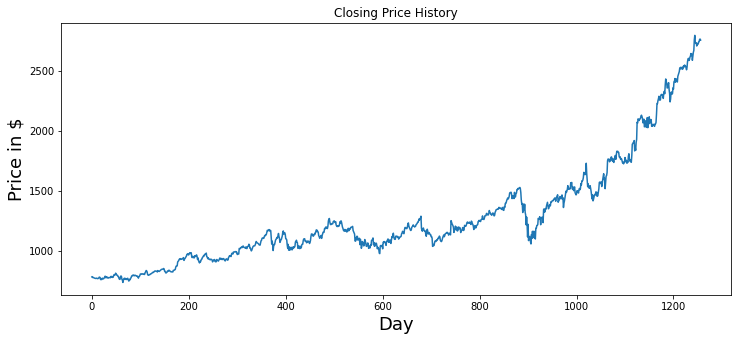

In [ ]:
plt.figure(figsize=(12,5))
plt.title('Closing Price History')
plt.plot(data)
plt.xlabel('Day',fontsize=18)
plt.ylabel('Price in $',fontsize=18)
plt.show

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data_array = scaler.fit_transform(np.array(data).reshape(-1,1))

In [ ]:
training_data_len = int(len(data)*0.65)
valid_data_len = len(data) - training_data_len

In [ ]:
train_data, test_data = data_array[0:training_data_len,:],data_array[training_data_len:len(data_array),:1]

In [ ]:
def create_dataset(data,time_step=1):
  dataX, dataY = [],[]
  for i in range(len(data)-time_step-1):
    a = data[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(data[i+time_step,0])
  return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
X_train,Y_train = create_dataset(train_data,time_step)
X_test, Y_test = create_dataset(test_data,time_step)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [ ]:
model = Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(32))
model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 100, 100)          40800     
_________________________________________________________________
lstm_31 (LSTM)               (None, 100, 100)          80400     
_________________________________________________________________
lstm_32 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 153,065
Trainable params: 153,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
12/12 [==============================] - 11s 478ms/step - loss: 0.0093 - val_loss: 0.0456
Epoch 2/50
12/12 [==============================] - 4s 323ms/step - loss: 0.0011 - val_loss: 0.0398
Epoch 3/50
12/12 [==============================] - 4s 326ms/step - loss: 6.5662e-04 - val_loss: 0.0127
Epoch 4/50
12/12 [==============================] - 4s 325ms/step - loss: 4.2246e-04 - val_loss: 0.0038
Epoch 5/50
12/12 [==============================] - 4s 329ms/step - loss: 3.7576e-04 - val_loss: 0.0035
Epoch 6/50
12/12 [==============================] - 4s 331ms/step - loss: 2.9537e-04 - val_loss: 0.0041
Epoch 7/50
12/12 [==============================] - 4s 327ms/step - loss: 2.8374e-04 - val_loss: 0.0044
Epoch 8/50
12/12 [==============================] - 4s 326ms/step - loss: 3.0501e-04 - val_loss: 0.0041
Epoch 9/50
12/12 [==============================] - 4s 326ms/step - loss: 2.8871e-04 - val_loss: 0.0028
Epoch 10/50
12/12 [==============================] - 4s 324ms/step - lo

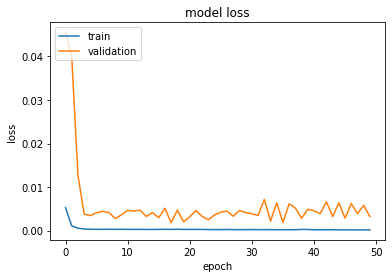

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_test,test_predict))

1815.3869303367912

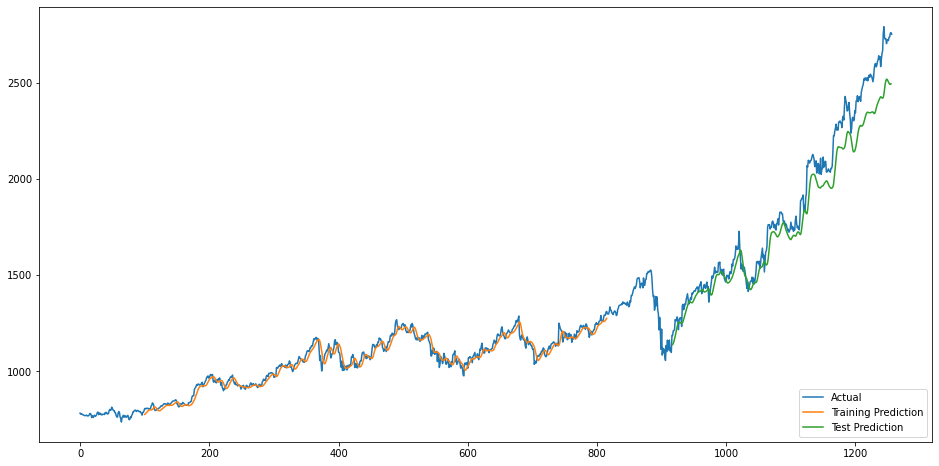

In [ ]:
look_back = 100
train_predict_plot = np.empty_like(data_array)
train_predict_plot[:,:] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back,:] = train_predict
test_predict_plot = np.empty_like(data_array)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(data_array)-1,:] = test_predict
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(data_array))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.legend(['Actual','Training Prediction','Test Prediction'], loc='lower right')
plt.show()

In [ ]:
len(test_data)

440

In [ ]:
x_input = test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [ ]:
lst_output = []
n_steps = 100
i = 0
while i < 30:
  if len(temp_input)>100:
    x_input = np.array(temp_input[1:])
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1,n_steps,1))
    yhat = model.predict(x_input,verbose=0)
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
    x_input = x_input.reshape(1,n_steps,1)
    yhat = model.predict(x_input,verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i = i+1
print(lst_output)

[0.86106235]
[[0.8610623478889465], [0.8506093621253967], [0.829200267791748], [0.8010574579238892], [0.7697257399559021], [0.7375887632369995], [0.7060911655426025], [0.676067590713501], [0.647996187210083], [0.6221491694450378], [0.5986698269844055], [0.5776064991950989], [0.5589299201965332], [0.542546808719635], [0.5283111929893494], [0.5160383582115173], [0.5055185556411743], [0.49652883410453796], [0.488844096660614], [0.48224541544914246], [0.4765267074108124], [0.47150006890296936], [0.4669977128505707], [0.46287477016448975], [0.45900923013687134], [0.4553012251853943], [0.45167285203933716], [0.4480656087398529], [0.4444385766983032], [0.44076594710350037]]


In [ ]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(data_array)

1257

In [ ]:
data1 = data_array.tolist()
data1.extend(lst_output)

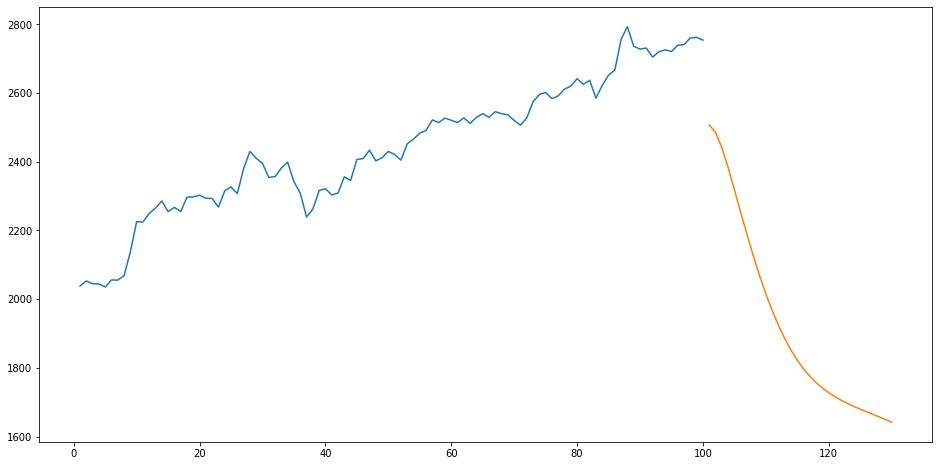

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(day_new,scaler.inverse_transform(data_array[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))